In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple

For **getting help** about parameters and return results:

`help(function_you_dont_know)`  
or use numpy info function   
`np.info(function_you_dont_know)`

In [74]:
class Neuron:    
    @staticmethod
    def integrate(U, I, dt, config):
        """
            Calculate next potentials list based on last potentials and Currents input which neurons get
            Cause numpy brodcasting ability, functions may work correct for single entry for ndarrays 

            Keyword arguments:
            U -- potentials array <numpy.ndarray>
            I -- current stands for internat and extrenal currents which every neurons recives <numpy.ndarray>
            dt -- time step for each step <float>
            config -- A matrix containg configuration for each of neurons <numpy.ndarray>
                      it must [u_rest, R, threshhold, tau] it use array keyword referencing.
            
            return:
            a tuple that contains (potentials, spikedActivity)
            potentials -- new potentials calculated based on Leaky integrated and fire dynamics <numpu.ndarray>
            spikedActivity -- boolean array which shows wheter neuron spiked in this step or not <numpy.ndarray>
        """
        u_rest = config['u_rest']
        potentials = ((u_rest - U) + config['R'] * I) * (dt / config['tau'])
        potentials[potentials >= config['threshhold']] = u_rest
        return potentials, potentials == u_rest
        
    @staticmethod
    def generate_config(tau=5, resistor=5, threshhold=-70, uRest=-65, noise=None):
        """ 
            generate configuration for variables make them noisy in if args presented

            Keyword arguments:
            tau -- time constant for decays (default=5)
            resistor -- (default=5)
            threshhold -- (default=-70)
            uRest -- (default=-65)
            noise -- setup for adding noise to configuration, make them not be exactly the same 
                    { size } (default=None)
                    size -- size of configuration

            return: configurations

            TODO: accept None in noise to prevent gauusain noise around specifi varibale
            TODO: accpet diffrent configs for noise parameter, make it possible to have diffrent noise for diffrent configs 
            TODO: separate size from noise
            TODO: move noise to higger level use case, and keep pop homogenous 
            TODO: setup dtype optimization for lower memory allocation  
        """

        if noise is None:
            return np.array(
                (tau, resistor, threshhold, uRest), 
                dtype=[('tau', 'f2'), ('R', 'f2'), ('threshhold', 'f2'), ('u_rest', 'f2')]
            )
        
        # noise generator from gussian normal distribution
        n = lambda v: v + np.random.normal(noise.get('mu', 0), noise.get('sigma', 1), noise.get('size', 100))

        return {
            'tau': n(tau),
            "R": n(resistor),
            "threshhold": n(threshhold),
            'u_rest': n(uRest)
        }

In [20]:
n = lambda x: 5 + np.random.normal(0, 1, 100) 
np.array(np.concatenate((n(9),n(1), n(3))),dtype=[('tau', 'f2'), ('R', 'f2'), ('threshold', 'f2')])

array([(4.3  , 4.3  , 4.3  ), (5.34 , 5.34 , 5.34 ),
       (3.404, 3.404, 3.404), (3.748, 3.748, 3.748),
       (5.625, 5.625, 5.625), (5.207, 5.207, 5.207),
       (4.613, 4.613, 4.613), (6.938, 6.938, 6.938),
       (5.49 , 5.49 , 5.49 ), (4.598, 4.598, 4.598),
       (5.797, 5.797, 5.797), (3.916, 3.916, 3.916),
       (5.03 , 5.03 , 5.03 ), (5.156, 5.156, 5.156),
       (4.508, 4.508, 4.508), (5.043, 5.043, 5.043),
       (7.105, 7.105, 7.105), (4.996, 4.996, 4.996),
       (4.97 , 4.97 , 4.97 ), (3.607, 3.607, 3.607),
       (4.594, 4.594, 4.594), (4.35 , 4.35 , 4.35 ),
       (5.4  , 5.4  , 5.4  ), (6.53 , 6.53 , 6.53 ),
       (5.555, 5.555, 5.555), (3.646, 3.646, 3.646),
       (3.492, 3.492, 3.492), (4.996, 4.996, 4.996),
       (4.96 , 4.96 , 4.96 ), (6.47 , 6.47 , 6.47 ),
       (5.703, 5.703, 5.703), (6.273, 6.273, 6.273),
       (5.164, 5.164, 5.164), (5.33 , 5.33 , 5.33 ),
       (4.445, 4.445, 4.445), (4.605, 4.605, 4.605),
       (4.93 , 4.93 , 4.93 ), (5.45 , 5.45 , 5

In [32]:
class Utils:
    @staticmethod
    def clamp(value, bound=None):
        """
            Clamp entry value between specified bound, no clamp will be done if bound is not specifeid
            Cause numpy brodcasting ability, functions may work correct for single entry for ndarrays

            Keyword arguments:
            value -- Values which gonna be clamped <numpy.ndarray>
            bound -- A tuple or an array contains lower, and upper bound [lower, upper] 
                     if bound length is less than 2 or no bound is specified no clamp will be applyed (default=None) 
            
            return: clampedValue

            TODO: accpet None as argument for skip min or max clamping
        """
        if (bound is None and len(bound) < 2):
            return w
        return np.min(bound[1], np.max(bound[0], value))

In [6]:
class Connection:
    """ Connect population A to population B with connection_type strategy
valid connection_types
    'full' for  full_connectivity,
    'fixedCP' for fixed_coupling_probability_connectivity,
    'fixedNPP' for fixed_number_of_presynaptics_parents,

For illiminate performance issue it doesn't connect neurons until calling @method for comp
"""
    def __init__(self, A, B, connection_type, **configs):
        """ connect A population to B population with input connection_type """
        self.pre = A.neurons
        self.post = B.neurons
        self.relations = []
        connect = {
            'full': Connection.full_connectivity,
            'fixedCP': Connection.fixed_coupling_probability_connectivity,
            'fixedNPP': Connection.fixed_number_of_presynaptics_parents,
        }.get(connection_type, fixedCP)

        connect(self.pre, self.post, **configs)

    @staticmethod
    def full_connectivity(A, B, p=0.1, J0=10, r0=1): 
        C = p * len(A) # p * N
        μ, σ = J0/C, r0/math.sqrt(C)
        normal = np.random.normal

        for pre in A:
            for post in B:
                relations.append([pre, post, normal(μ, σ)])
    
    @staticmethod
    def fixed_coupling_probability_connectivity(A, B, p=0.1, J0=10, r0=1): 
        """ p := coupling_probability """
        CA_size = int(p * len(A))
        CB_size = int(p * len(B))
        μ, σ = J0/CB_size, r0/math.sqrt(CB_size)
        normal = np.random.normal

        for pre in np.random.choice(A, CA_size, replace=False):
            for post in np.random.choice(B, CB_size, replace=False):
                relations.append([pre, post, normal(μ, σ)])

    
    @staticmethod
    def fixed_number_of_presynaptics_parents(A, B, p=0.1, J0=10, r0=1): 
        C = int(p * len(A))
        μ, σ = J0/C, r0/math.sqrt(C)
        normal = np.random.normal
        
        for post in B:
            for pre in np.random.choice(A, C, replace=False):
                relations.append([pre, post, normal(μ, σ)])

    def update():
        """ 
            For every post of spiked neuron you should update Ii 
            For stdp learning it should update Ws
        """
        pass

In [14]:
class Layer:
    def __init__(self, *args):
        self.__iterators = args

    def foreach(self, fn):
        for items in self.__iterators:
            fn(items)

In [15]:
a = Layer(5, 6, 7)
a.foreach(lambda x: print(x**2))

25
36
49


In [ ]:
def get_homogenous_group():
    pass

In [2]:
# TODO: seems not to be needed any more
def clamp(w, bound=None):
    if (bound is None and len(bound) != 2):
        return w
    # bound[0] <= w <= bound[1]
    return min(bound[1], max(bound[0], w))

# TODO: hard code configs and will change soon!
W_MAX = 1
ηn = 0.0265625
ηp = 0.03125 
def soft_bound_Ap(w, w_max=W_MAX, nu_positive=ηp):    
    return (w_max - w) * nu_positive

def soft_bound_An(w, nu_negative=ηn):
    return w * nu_negative

class Learning:
    @staticmethod
    def stdp(w, t_pre, t_post, **config):
        # TODO: Performace boost can be added make it classmethod or normal method
        # deafult values
        Ap    = config.get('Ap', soft_bound_Ap)
        An     = config.get('An', soft_bound_An)
        taup  = config.get('taup', 0.0337)
        taun   = config.get('taun', 0.0168)
        
        Δt =  t_post - t_pre
        if (Δt >= 0):
            Δw =  Ap(w) * np.exp(-abs(Δt) / taup)    
        else:
            Δw =  An(w) * np.exp(-abs(Δt) / taun)
        return Δw, Δt

In [166]:
def gauss(mu, sigma):
    def _gauss(value):
        return value + random.gauss(mu, sigma)
    return _gauss

class Configuration:
    # μ = 0
    # σ = 1
    @staticmethod
    def lif_config_generator(tau=5, resistor=5, threshold=-65, uRest=-70, noise=None):
        """ return generated """
        # TODO: hardcoded generators 
        if noise is None:
            return np.array(
                (tau, resistor, threshold, uRest), 
                dtype=[('tau', 'f2'), ('R', 'f2'), ('threshold', 'f2'), ('uRest', 'f2')]
            )
        n = gauss(noise['mu'], noise['sigma'])
        return np.fromiter(
                ((n(tau), n(resistor), n(threshold), n(uRest)) for _ in range(noise['size'])),
                dtype=[('tau', 'f2'), ('R', 'f2'), ('threshold', 'f2'), ('uRest', 'f2')]
                )

In [167]:
x = Configuration.lif_config_generator()

In [66]:
class Population:
    """ Gonna Handle homogenous population """
    def __init__(self, neuron, config_generator ,**configs):
        dt = configs.get('time_step', 0.1) 
        duration = configs.get('duration', 5)        
        self.time_series = np.arange(0,duration,dt)
        self.size = configs.get('size', 1000)

        self.potentials_series = np.empty((self.size, self.time_series.size))
        # Neurons (homogenous)
        self.neuron_configs = Configuration.
        # initialize neurons potentials
        self.potentials_series[:, 0] = self.neuron_configs['u_rest']

    def yeChizi(self):
        pass
    
    def activate(self, t):
        """ Activate a population """
        assert 1 <= t < self.time_series.size, 'Please Enter an integer belongs to [0, duration/dt) range as an index.'
        # TODO: need I_ext calculation from static fixed I ~ N(μ, σ), or separated for each individual
        IextPlusIi = 35
        integration_fn = Neuron.integrate
        integration_fn(self.potentials_series[:, t-1], IextPlusIi, allNeuronsConfigs)
        potentials = np.fromiter(
            (n.integrate(IextPlusIi) for (index, n) in enumerate(self.neurons)),
            np.dtype([('u', 'f'), ('spiked','?')])
        )
        self.potentials_series[:, t] = potentials['u']
        # update interanl I for neurons has spiked in very last time potentials['spiked']
        return potentials

In [67]:
dt = 0.1
cgen_i = Configuration.lif_config_generator(dt, True)
cgen_e = Configuration.lif_config_generator(dt, False)

pop_excitatory = Population(Neuron, cgen_e, size=80)
pop_inhibitory = Population(Neuron, cgen_i, size=20)


In [68]:
pop_excitatory.activate(0)

array([[-70.,   0.,   0., ...,   0.,   0.,   0.],
       [-70.,   0.,   0., ...,   0.,   0.,   0.],
       [-70.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [-70.,   0.,   0., ...,   0.,   0.,   0.],
       [-70.,   0.,   0., ...,   0.,   0.,   0.],
       [-70.,   0.,   0., ...,   0.,   0.,   0.]])

## First Question
Unsupervised STDP learning for two nuerons and show w updates

In [46]:
# TODO: Hard Code dt change this in next session
dt = 0.1
lif_config = Configuration.lif_static_config()
pre = Neuron(lif_config(**{
                "tau" :5, 
                "resistor": 5,
                "threshold": -65,
                "uRest": -70,
                "dt": dt, 
                "isInhibitory": False
            }))
post = Neuron(lif_config(**{
                "tau" :5, 
                "resistor": 5,
                "threshold": -65,
                "uRest": -70,
                "dt": dt, 
                "isInhibitory": False
            }))

In [ ]:
#   @staticmethod
#     def normal(mu=0, sigma=1, size=None):
#         """
#             generate Random random distribution number around spcific value
            
#             Keyword arguments:
#             mu -- Mean (“centre”) of the distribution. <float>
#             sigma -- Standard deviation (spread or “width”) of the distribution. Must be non-negative. <float>
#             size -- <int> 

#             return: clampedValue

#             TODO: accpet None as argument for skip min or max clamping
#         """
        
#         def __gaussian_normal(value):
#             return value + np.random.normal(mu, sigma, size) 
#         return __gaussian_normal


    # def updateIinput():
    #     pass

    # update Ii
    # Handle for synapse in self.posts:
    #     synapse.neuron.input += pow(-1,self.isi) * synapse.w * (self.θ - self.u_rest)

PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False
POST False
PRE  True
POST True
PRE  False
POST False
PRE  False
POST False
PRE  False

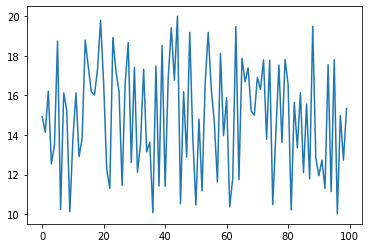

In [71]:
w = 10 # 2/2*0.1 J0/NP
duration = 10
time_series = np.arange(0, duration, dt)
# TODO: will config best looking stabe I
I = (np.ones_like(time_series)+np.random.random(time_series.shape)) * 10
plt.plot(I)
for current in I:
    print('PRE ', pre.integrate(current)[1])
    print('POST', post.integrate(current)[1])
